In [5]:
import os
import ot
import ot.plot
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

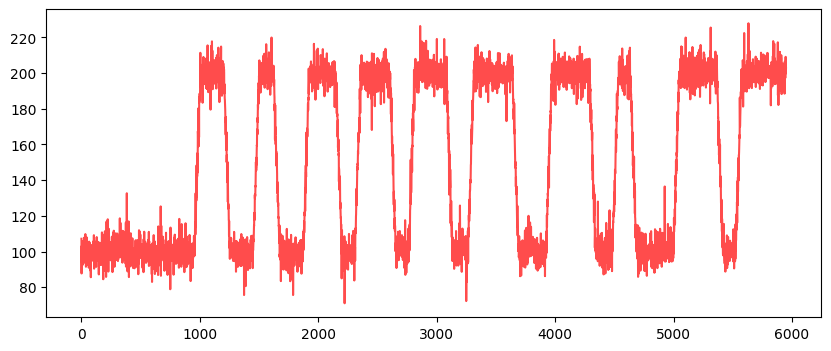

In [6]:
data = np.loadtxt("data/sigma_5_transition_50.txt")
plt.figure(figsize=(10, 4))

plt.plot(np.arange(len(data)), data, 'r', alpha=0.7)


In [7]:
from ot import emd2_1d

def metric_wasserstein_change_points(data, w):
    n = len(data)
    distances = np.zeros((n))
    for t in tqdm(range(w, n - w)):
        a = data[t - w : t]
        b = data[t : t + w]
        distances[t] = emd2_1d(a, b)
    return distances

def Wass_dists(data, n, s):
    cpd_stat = np.zeros(len(data)// s, )
    count = 0
    for i in range(0, len(data)-s, s):
        if i<n or i>= len(data)- n:
            cpd_stat[count] = 0
        else:
            x, y = data[i-n:i], data[i: i+n]
            cpd_stat[count] = ot.emd2_1d(x, y)
        count += 1
    return cpd_stat 

def M1(wass_dists, quantile):
    change_points = []
    greater_than_quantile = []
    time = []
    for i in range(len(wass_dists)):
        if wass_dists[i] > quantile:
            greater_than_quantile.append(wass_dists[i])
            time.append(i)
        else:
            if len(greater_than_quantile) == 0:
                pass
            else:
                ind = min(time)
                change_points.append(np.argmax(greater_than_quantile)+ind)
                greater_than_quantile=[]
                time=[]
    return change_points

def M2_top(gradient, quantile_top):
    change_points=[]
    greater_than_quantile = []
    time=[]
    for i in range(len(gradient)):
        if gradient[i] > quantile_top:
            greater_than_quantile.append(gradient[i])
            time.append(i)
        else:
            if len(greater_than_quantile) == 0:
                pass
            else:
                ind = min(time)
                change_points.append(np.argmax(greater_than_quantile)+ind)
                greater_than_quantile=[]
                time=[]

    return change_points

def M2_bot(gradient, quantile_bot):
    change_points=[]
    less_than_quantile = []
    time=[]
    for i in range(len(gradient)):
        if gradient[i] < quantile_bot:
            less_than_quantile.append(gradient[i])
            time.append(i)
        else:
            if len(less_than_quantile) == 0:
                pass
            else:
                ind = min(time)
                change_points.append(np.argmin(less_than_quantile)+ind)
                less_than_quantile=[]
                time=[]

    return change_points

def M3(wass_dists, gradient, quantile):
    maxima_indices = []
    grad = []
    time = []
    for i in range(len(wass_dists)):
        if wass_dists[i] > quantile:
            grad.append(gradient[i])
            time.append(i)
        else:
            if len(grad) == 0:
                pass
            else:
                ind = min(time)
                maxima_indices.append((np.argmax(grad) + ind))
                maxima_indices.append((np.argmin(grad) + ind))
                grad = []
                time = []

    return maxima_indices

# Comparing Results on Toy data

# Method 1: Quantiles of Wasserstein distances on Toy data

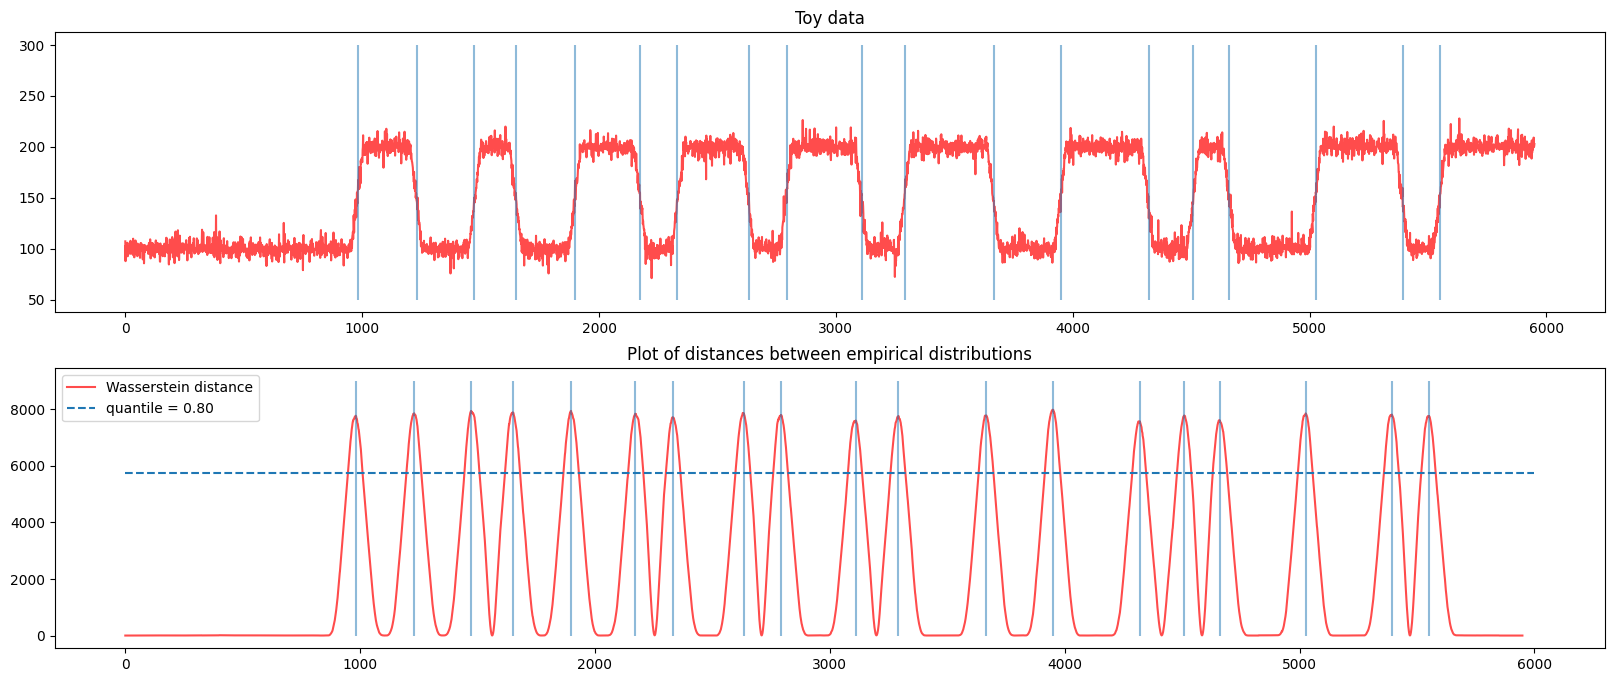

In [15]:
W_dists_M1 = Wass_dists(data, 100, 1)
quantile_M1 = np.quantile(W_dists_M1, 0.80)
cps_M1 = M1(W_dists_M1, quantile_M1)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.plot(np.arange(len(data)), data, 'r', alpha=0.7)
ax2.plot(np.arange(len(W_dists_M1)), W_dists_M1, 'r', alpha=0.7, label='Wasserstein distance')
ax2.hlines(quantile_M1,0,6000, linestyles='dashed', label='quantile = 0.80')
for i in cps_M1:
    ax1.vlines(i,50,300,alpha=0.5)
    ax2.vlines(i,0,9000,alpha=0.5)

ax1.set_title("Toy data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

# Method 2: Quantiles of gradient of Wasserstein distances

100%|██████████| 5750/5750 [00:01<00:00, 3968.92it/s]


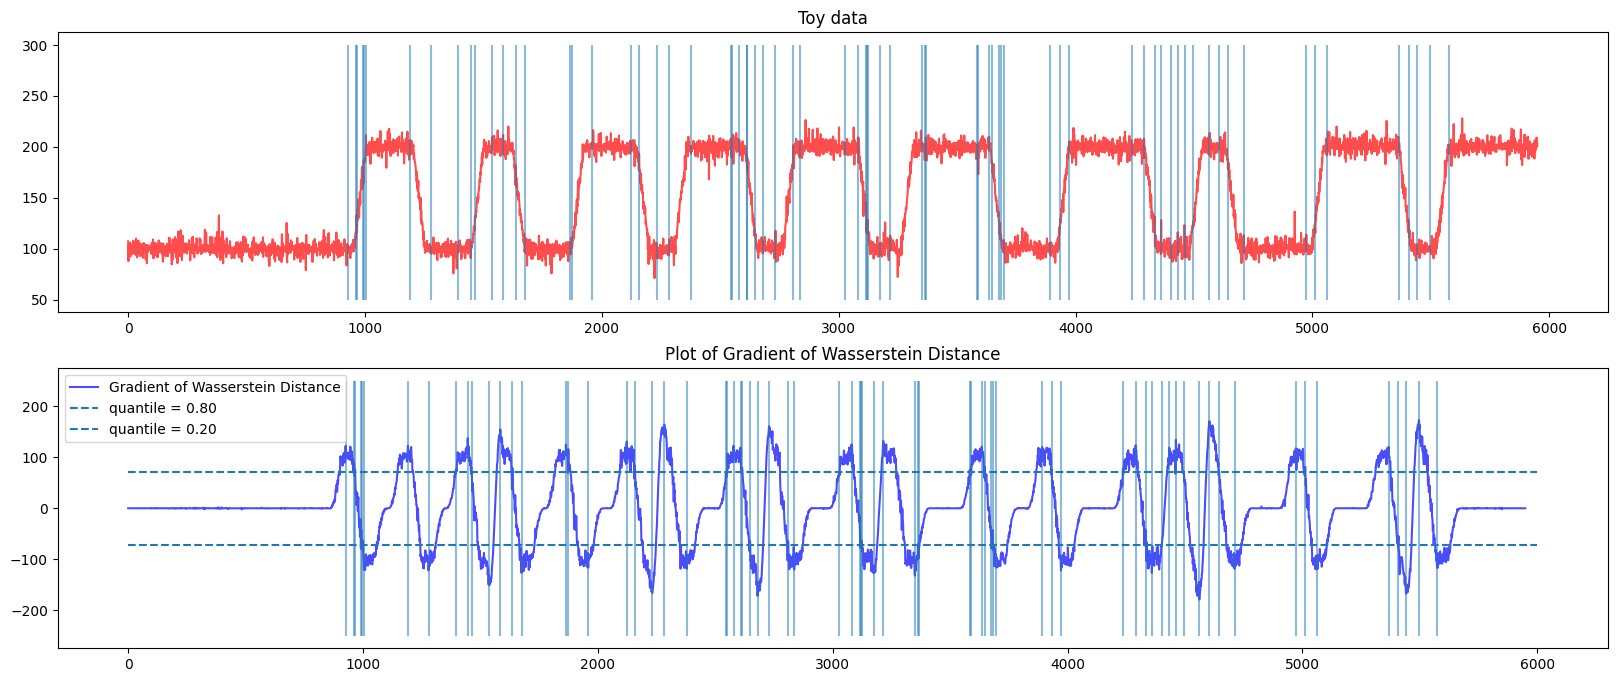

In [65]:
W_dists_M2 = metric_wasserstein_change_points(data, 100)
grad_M2 = np.gradient(W_dists_M2)
quantile_M2_top = np.quantile(grad_M2, 0.8)
quantile_M2_bot = np.quantile(grad_M2, 0.2)
cps_M2_top = M2_top(grad_M2, quantile_M2_top)
cps_M2_bot = M2_bot(grad_M2, quantile_M2_bot)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.plot(np.arange(len(data)), data, c='r', alpha=0.7)
ax2.plot(np.arange(len(grad_M2)), grad_M2, c='b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M2_top,0,6000, linestyles='dashed', label='quantile = 0.80')
ax2.hlines(quantile_M2_bot,0,6000, linestyles='dashed', label='quantile = 0.20')
for i in cps_M2_top:
    ax1.vlines(i,50,300,alpha=0.5)
    ax2.vlines(i,-250,250,alpha=0.5)
for i in cps_M2_bot:
    ax1.vlines(i,50,300,alpha=0.5)
    ax2.vlines(i,-250,250,alpha=0.5)

ax1.set_title("Toy data")
ax2.set_title("Plot of Gradient of Wasserstein Distance")
plt.legend()

# Method 3: Combining quantile of Wasserstein distances and its gradient

100%|██████████| 5680/5680 [00:04<00:00, 1267.41it/s]


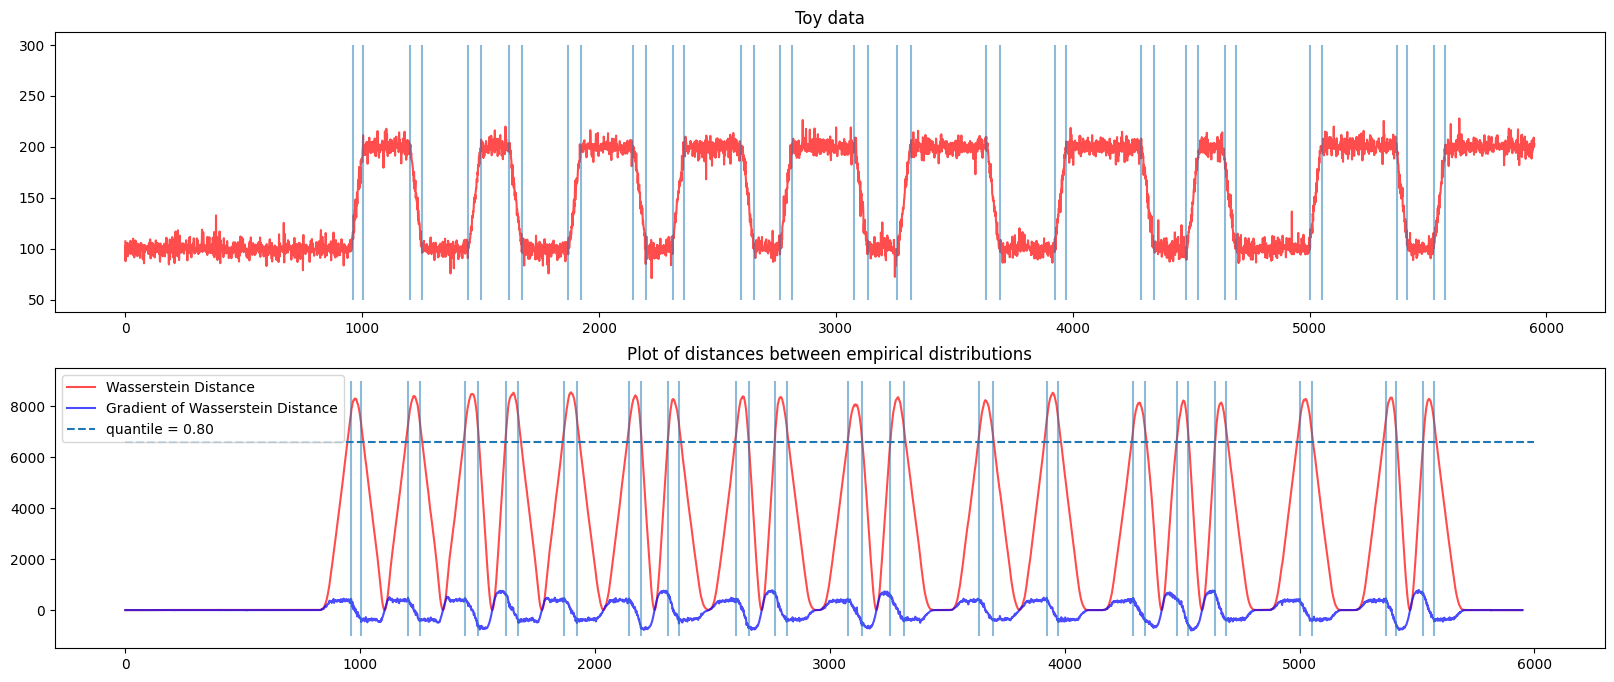

In [8]:
#W_dists_M3 = Wass_dists(data, 900, 1)
W_dists_M3 = metric_wasserstein_change_points(data, 135)
quantile_M3 = np.quantile(W_dists_M3, 0.8)
grad_M3 = np.gradient(W_dists_M3)
cps_M3 = M3(W_dists_M3, grad_M3, quantile_M3)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.plot(np.arange(len(data)), data, 'r', alpha=0.7)
ax2.plot(np.arange(len(W_dists_M3)), W_dists_M3, 'r', alpha=0.7, label='Wasserstein Distance')
ax2.plot(np.arange(len(grad_M3)), grad_M3*5, 'b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M3,0,6000, linestyles='dashed', label='quantile = 0.80')

for i in cps_M3:
    ax1.vlines(i,50,300,alpha=0.5)
    ax2.vlines(i,-1000,9000,alpha=0.5)

ax1.set_title("Toy data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

# Method 4: Filtering CPs

In [154]:

def identify_change_points(differences: np.ndarray, q=0.80) -> np.ndarray:
    change_pts = []
    cutoff = np.quantile(differences, q)
    for index, dist in enumerate(differences):
        if dist > cutoff:
            change_pts.append(index)
    return np.array(change_pts)

def filter_change_points(
    differences: np.ndarray,
    change_points: np.ndarray,
) -> np.ndarray:
    # find the boundaries of the regions containing consecutive CP candidates
    boundary_pts = []
    for i in range(len(change_points) - 1):
        if change_points[i + 1] - change_points[i] > 1:
            boundary_pts.append(change_points[i])
            boundary_pts.append(change_points[i + 1])

    # filter for and output the final change points
    filtered_points = []
    for i in range(len(boundary_pts) - 1):
        lo = boundary_pts[i]
        hi = boundary_pts[i + 1]
        if hi - lo > 1:
            subset = differences[lo:hi]
            if type(subset) is not np.ndarray:
                subset = np.array(subset)
            filtered_points.append(subset.argmax() + lo)
    return np.array(filtered_points)


In [152]:
W_dists = metric_wasserstein_change_points(data, 100)
ID_pts = identify_change_points(W_dists)
detected = filter_change_points(W_dists, ID_pts)

100%|██████████| 5750/5750 [00:02<00:00, 2115.78it/s]


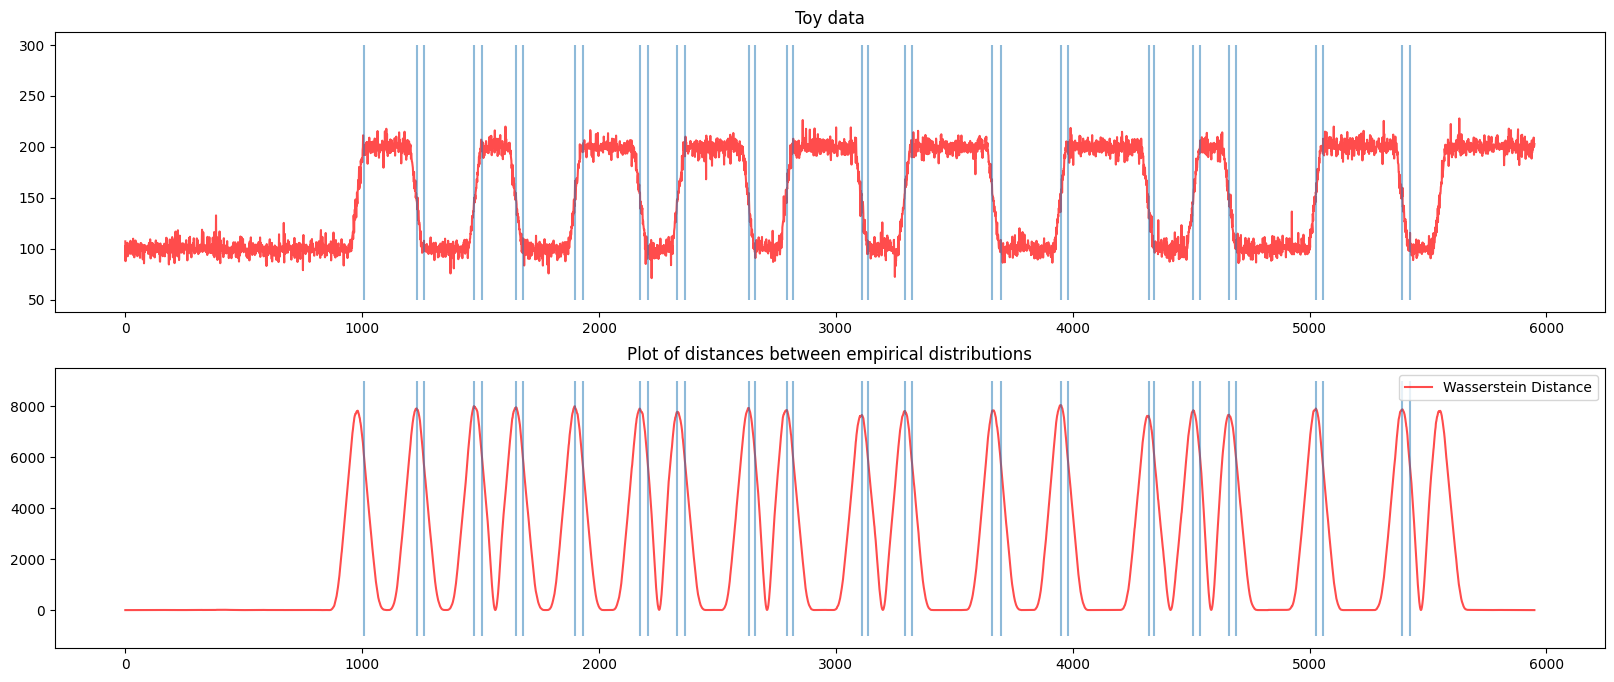

In [153]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.plot(np.arange(len(data)), data, 'r', alpha=0.7)
ax2.plot(np.arange(len(W_dists)), W_dists, 'r', alpha=0.7, label='Wasserstein Distance')
#ax2.hlines(cutoff,0,6000, linestyles='dashed', label='quantile = 0.80')

for i in detected:
    ax1.vlines(i,50,300,alpha=0.5)
    ax2.vlines(i,-1000,9000,alpha=0.5)

ax1.set_title("Toy data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

# Langevin Data

In [44]:
lang = np.loadtxt("data/Langevin_1D.txt")
#W_dists_M3 = Wass_dists(lang, 450, 1)
W_dists_M3 = metric_wasserstein_change_points(lang, 450)
quantile_M3 = np.quantile(W_dists_M3, 0.80)
grad_M3 = np.gradient(W_dists_M3)
cps_M3 = M3(W_dists_M3, grad_M3, quantile_M3)

100%|██████████| 99100/99100 [00:30<00:00, 3284.41it/s]


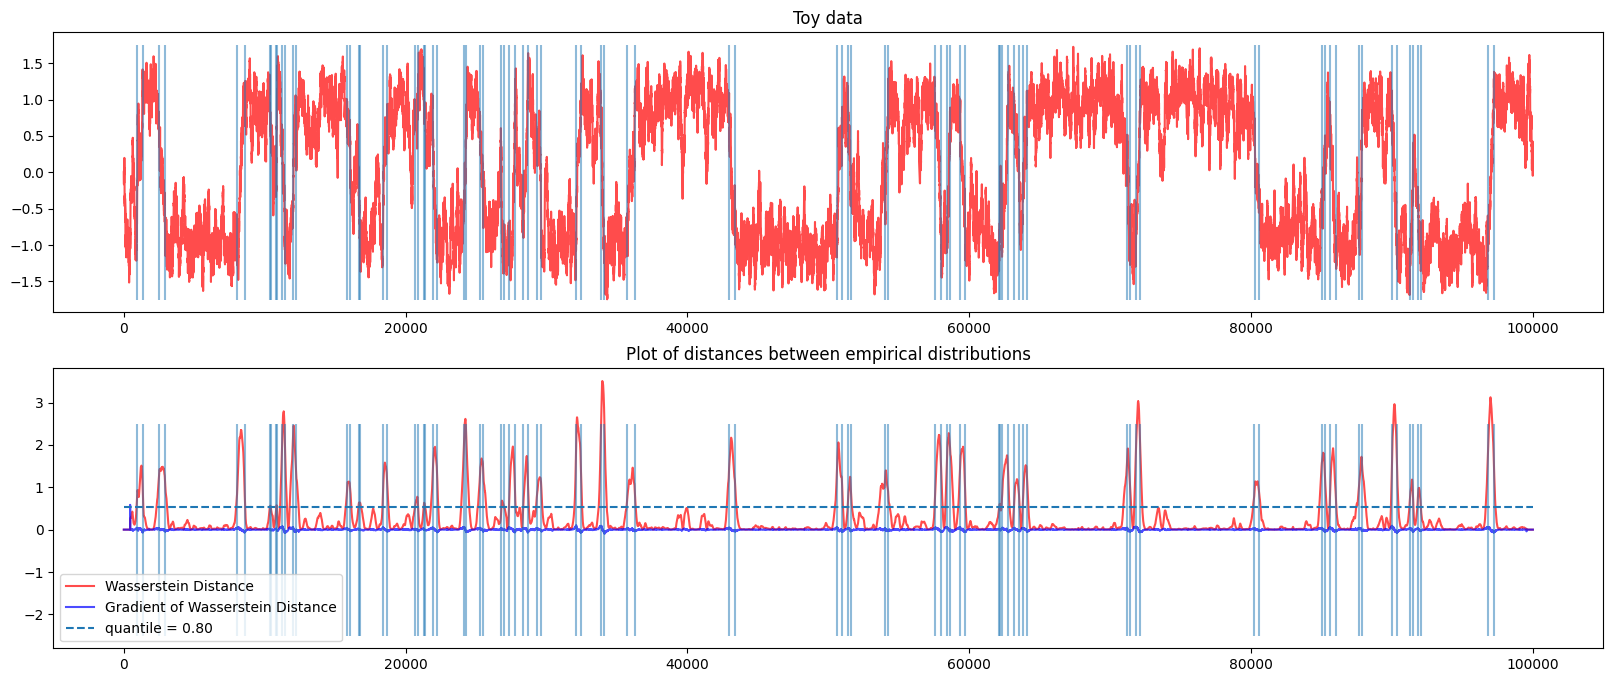

In [45]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.plot(np.arange(len(lang)), lang, 'r', alpha=0.7)
ax2.plot(np.arange(len(W_dists_M3)), W_dists_M3, 'r', alpha=0.7, label='Wasserstein Distance')
ax2.plot(np.arange(len(grad_M3)), grad_M3*5, 'b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M3,0,100000, linestyles='dashed', label='quantile = 0.80')

for i in cps_M3:
    ax1.vlines(i,-1.75,1.75,alpha=0.5)
    ax2.vlines(i,-2.5,2.5,alpha=0.5)

ax1.set_title("Lang data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

# ADP data

In [9]:
data_shifted = np.loadtxt("data/ADP_2D.txt")
df = pd.read_csv('ADP_data/A_2D_1ps.dat', header=None, skipinitialspace=True, sep=' ', names=['phi', 'psi'])
points = np.array(df)[0:50000]
pts = np.array(df)

phi = points[:,0]
psi = points[:,1]
psi_shifted = data_shifted[0:50000,1]

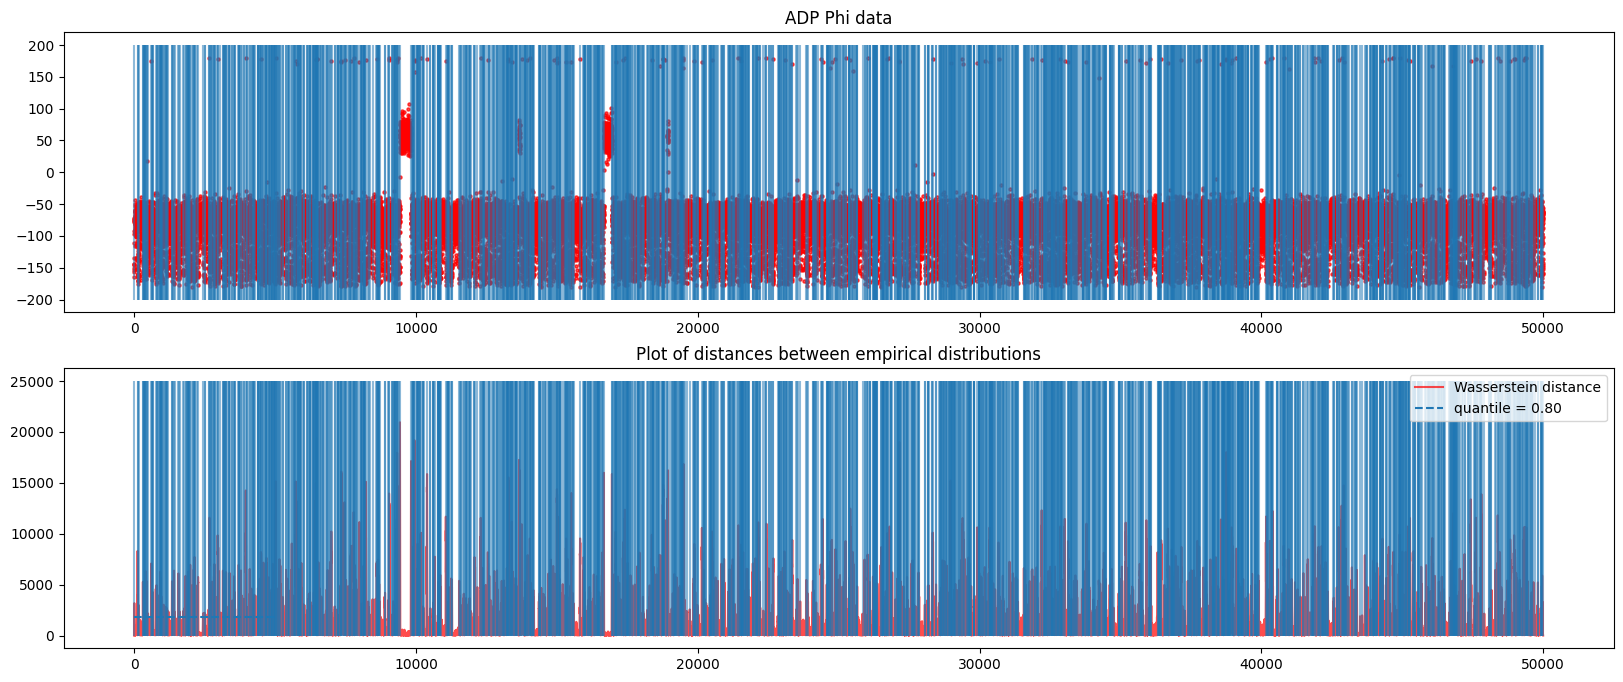

In [13]:
W_dists_M1 = Wass_dists(phi, 10, 1)
quantile_M1 = np.quantile(W_dists_M1, 0.75)
cps_M1 = M1(W_dists_M1, quantile_M1)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.scatter(np.arange(len(phi)), phi, c='r', alpha=0.7,s=5)
ax2.plot(np.arange(len(W_dists_M1)), W_dists_M1, 'r', alpha=0.7, label='Wasserstein distance')
ax2.hlines(quantile_M1,0,5000, linestyles='dashed', label='quantile = 0.80')
for i in cps_M1:
    ax1.vlines(i,-200,200,alpha=0.5)
    ax2.vlines(i,0,25000,alpha=0.5)

ax1.set_title("ADP Phi data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

100%|██████████| 4980/4980 [00:02<00:00, 2339.37it/s]


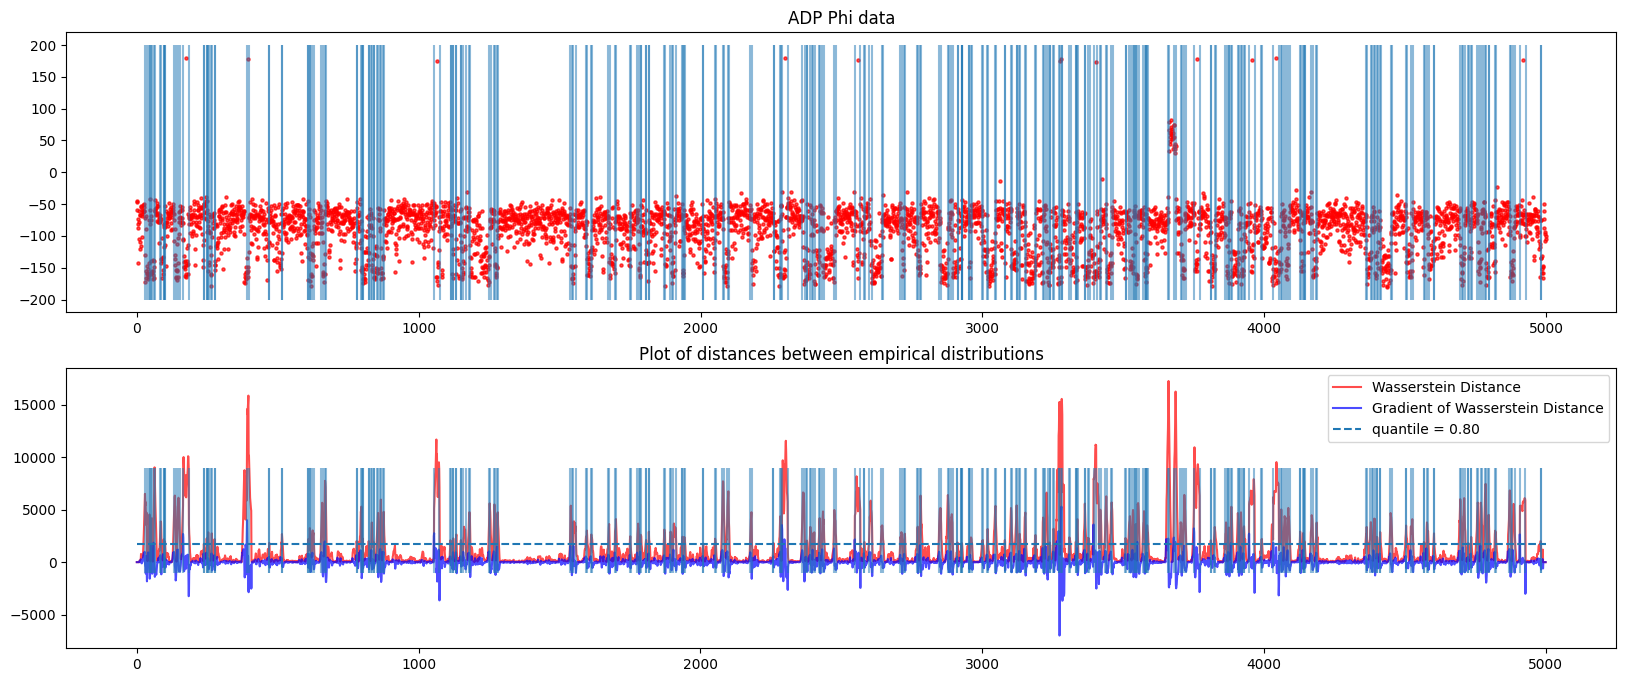

In [19]:
#W_dists_M3 = Wass_dists(data, 900, 1)
W_dists_M3 = metric_wasserstein_change_points(phi, 10)
quantile_M3 = np.quantile(W_dists_M3, 0.75)
grad_M3 = np.gradient(W_dists_M3)
cps_M3 = M3(W_dists_M3, grad_M3, quantile_M3)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,8))

ax1.scatter(np.arange(len(phi)), phi, c='r', alpha=0.7,s=5)
ax2.plot(np.arange(len(W_dists_M3)), W_dists_M3, 'r', alpha=0.7, label='Wasserstein Distance')
ax2.plot(np.arange(len(grad_M3)), grad_M3, 'b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M3,0,5000, linestyles='dashed', label='quantile = 0.80')

for i in cps_M3:
    ax1.vlines(i,-200,200,alpha=0.5)
    ax2.vlines(i,-1000,9000,alpha=0.5)

ax1.set_title("ADP Phi data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

In [17]:
#W_dists_M3 = Wass_dists(data, 900, 1)
psi_shifted = data_shifted[0:50000,1]
W_dists_M3 = metric_wasserstein_change_points(psi_shifted, 15)
quantile_M3 = np.quantile(W_dists_M3, 0.8)
grad_M3 = np.gradient(W_dists_M3)
cps_M3 = M3(W_dists_M3, grad_M3, quantile_M3)

print(len(cps_M3))
diff = [abs(cps_M3[i+1] - cps_M3[i]) for i in range(len(cps_M3)-1)]
print(np.mean(diff))

100%|██████████| 49970/49970 [00:24<00:00, 2037.65it/s]


1140
43.580333625987706


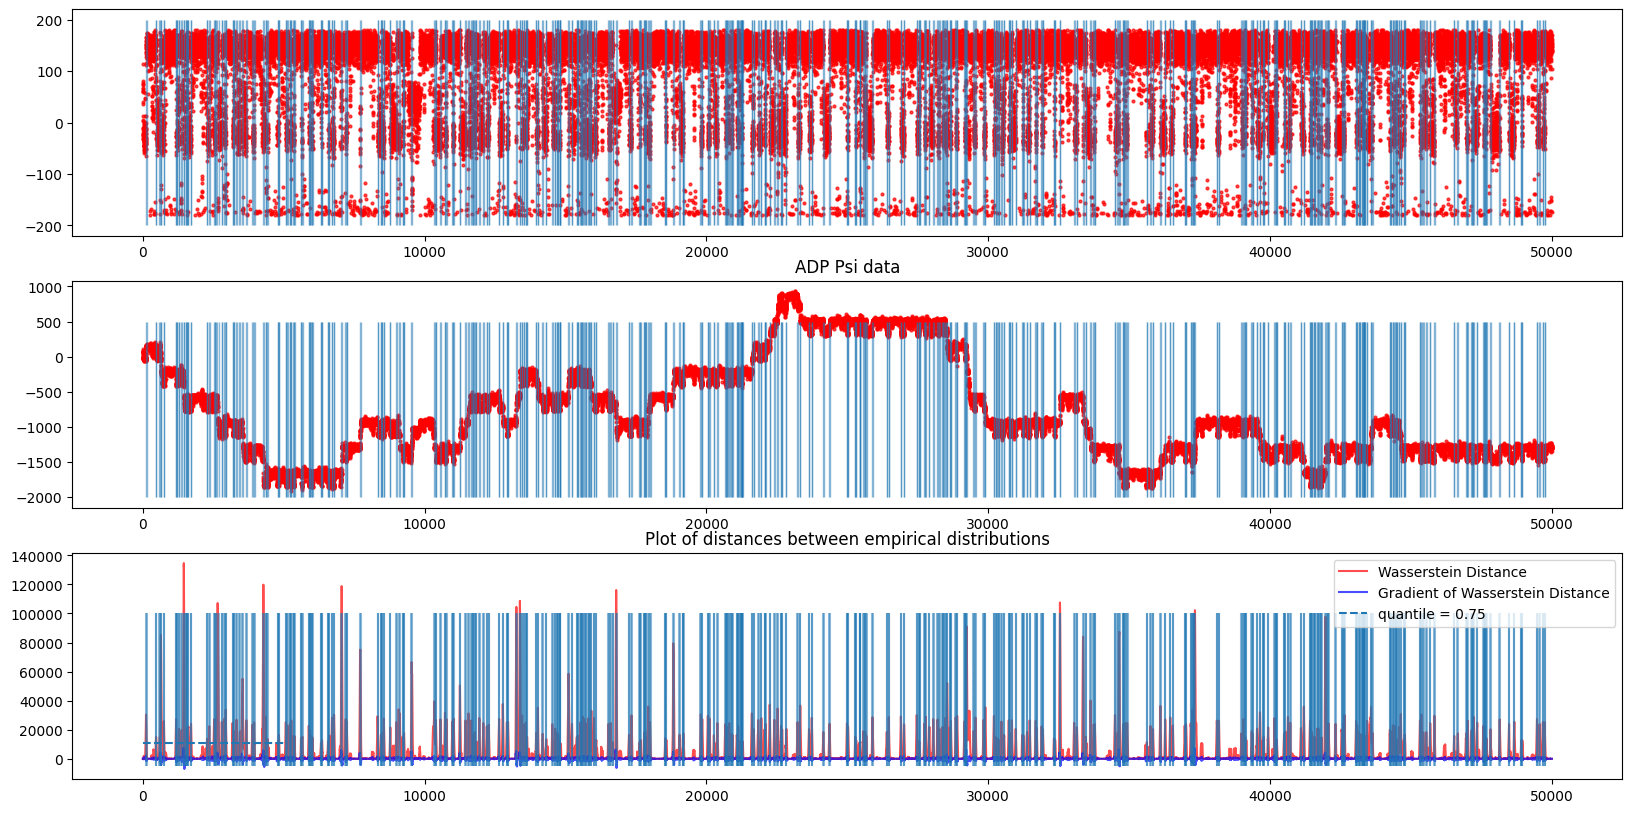

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(20,10))

ax0.scatter(np.arange(len(psi)), psi, c='r', alpha=0.7,s=4)
ax1.scatter(np.arange(len(psi_shifted)), psi_shifted, c='r', alpha=0.7,s=4)
ax2.plot(np.arange(len(W_dists_M3)), W_dists_M3, 'r', alpha=0.7, label='Wasserstein Distance')
ax2.plot(np.arange(len(grad_M3)), grad_M3, 'b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M3,0,5000, linestyles='dashed', label='quantile = 0.75')

for i in cps_M3:
    ax0.vlines(i,-200,200,alpha=0.5, linewidth=1)
    ax1.vlines(i,-2000,500,alpha=0.5, linewidth=1)
    ax2.vlines(i,-5000,100000,alpha=0.5)

ax1.set_title("ADP Psi data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()

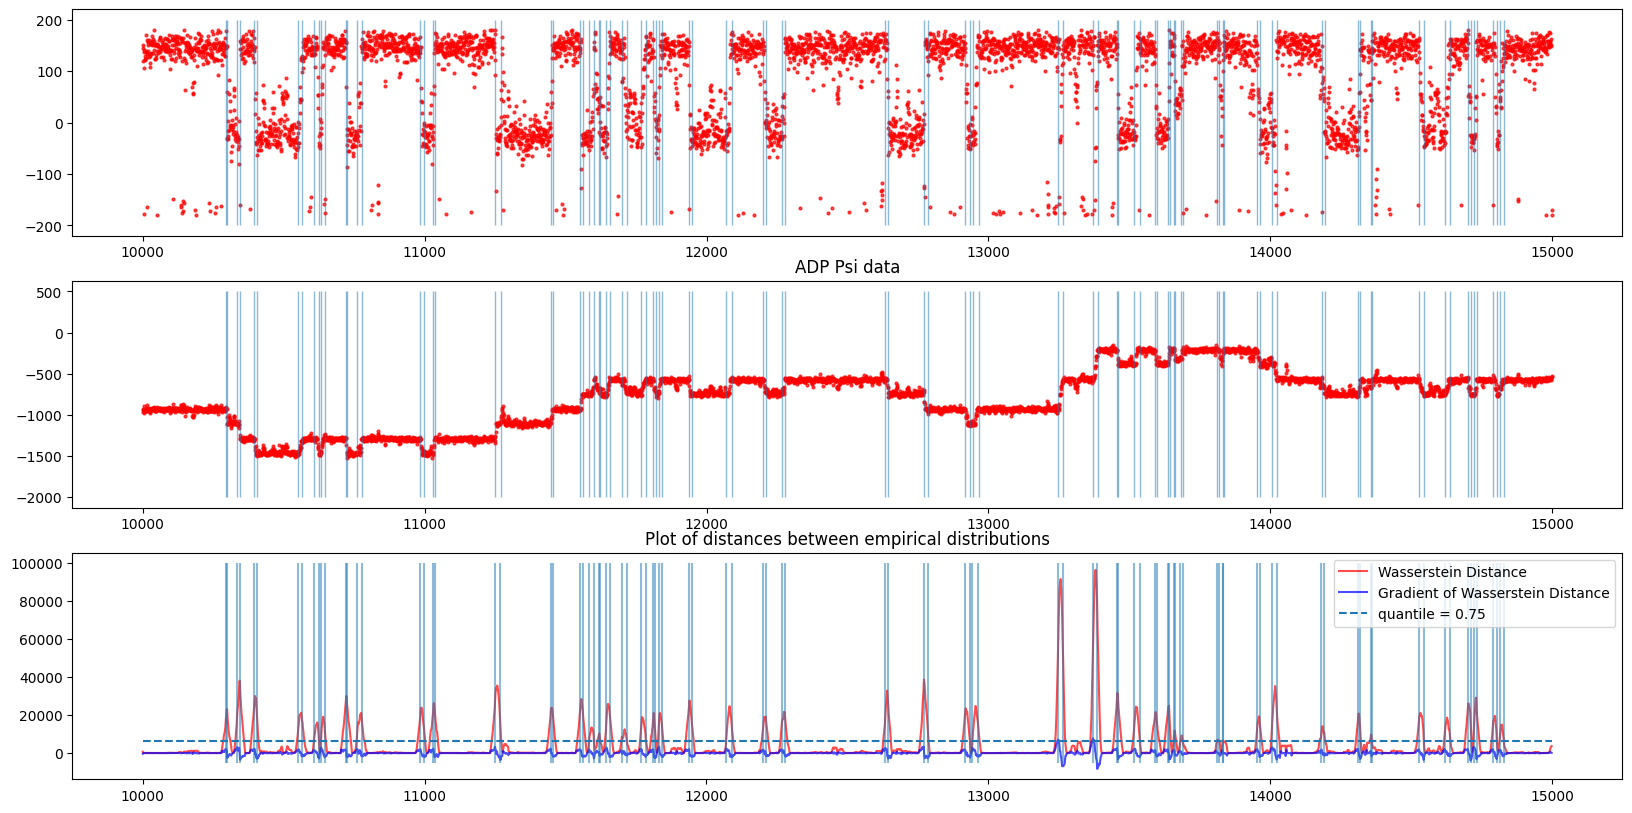

In [26]:
#Zoom in:
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(20,10))

start = 10000
end   = 15000

ax0.scatter(np.arange(start,end), psi[start:end], c='r', alpha=0.7,s=4)
ax1.scatter(np.arange(start,end), psi_shifted[start:end], c='r', alpha=0.7,s=4)
ax2.plot(np.arange(start,end), W_dists_M3[start:end], 'r', alpha=0.7, label='Wasserstein Distance')
ax2.plot(np.arange(start,end), grad_M3[start:end], 'b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M3,start,end, linestyles='dashed', label='quantile = 0.75')

cps_M3 = np.array(cps_M3)
condition = (cps_M3 > start) & (cps_M3 < end)

for i in cps_M3[condition]:
    ax0.vlines(i,-200,200,alpha=0.5, linewidth=1)
    ax1.vlines(i,-2000,500,alpha=0.5, linewidth=1)
    ax2.vlines(i,-5000,100000,alpha=0.5)

ax1.set_title("ADP Psi data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()


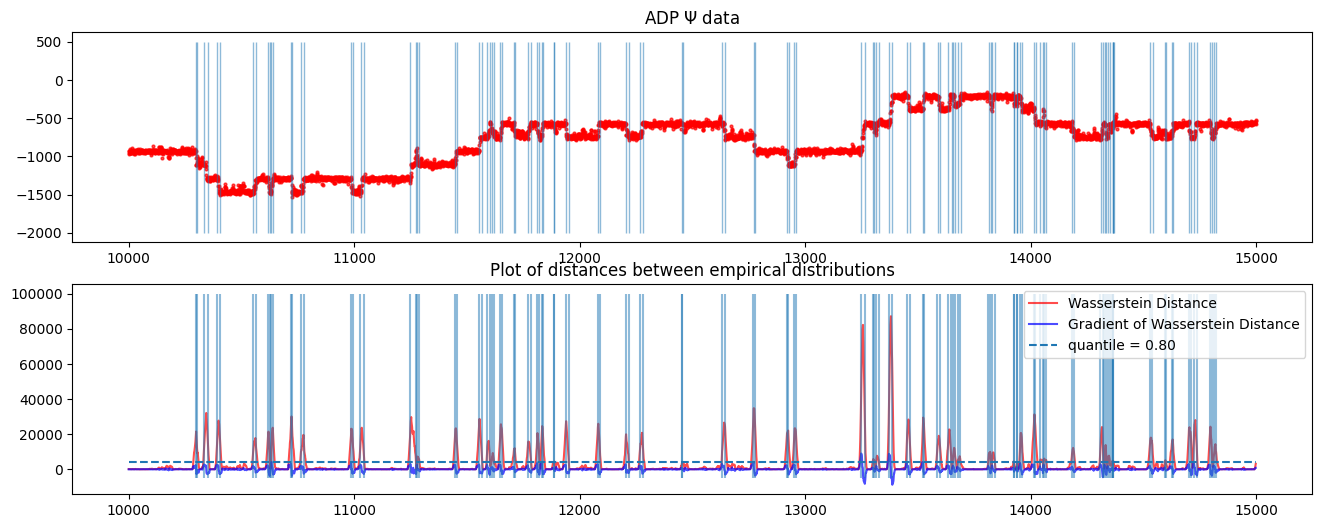

In [18]:
#Zoom in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6))

start = 10000
end   = 15000

#ax0.scatter(np.arange(start,end), psi[start:end], c='r', alpha=0.7,s=4)
ax1.scatter(np.arange(start,end), psi_shifted[start:end], c='r', alpha=0.7,s=4)
ax2.plot(np.arange(start,end), W_dists_M3[start:end], 'r', alpha=0.7, label='Wasserstein Distance')
ax2.plot(np.arange(start,end), grad_M3[start:end], 'b', alpha=0.7, label='Gradient of Wasserstein Distance')
ax2.hlines(quantile_M3,start,end, linestyles='dashed', label='quantile = 0.80')

cps_M3 = np.array(cps_M3)
condition = (cps_M3 > start) & (cps_M3 < end)

for i in cps_M3[condition]:
    #ax0.vlines(i,-200,200,alpha=0.5, linewidth=1)
    ax1.vlines(i,-2000,500,alpha=0.5, linewidth=1)
    ax2.vlines(i,-5000,100000,alpha=0.5)

ax1.set_title("ADP $\Psi$ data")
ax2.set_title("Plot of distances between empirical distributions")
plt.legend()
